<a href="https://colab.research.google.com/github/KillerStrike17/10DaysofMLChallenge/blob/master/Day5/Day5_Dog_Cat_Classifier_on_GPU_Using_Transfer_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Day 5

## Import Libraries

In [1]:
!nvidia-smi

Sun Mar 29 21:26:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Code to Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#calling the Gods
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2,preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import matplotlib.gridspec as gridspec
import scipy

TensorFlow 1.x selected.


## Data Extraction

In [0]:
!cp  /content/gdrive/My\ Drive/Kaggle_Competitions_Dataset/Dog_Cat_Dataset/cats_and_dogs_filtered.zip /content/

In [5]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

In [6]:
print(tf.__version__)

1.15.2


In [0]:
data_dir = pathlib.Path('/content/cats_and_dogs_filtered/train')

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['dogs', 'cats'], dtype='<U4')

In [10]:
train_it = datagen.flow_from_directory('cats_and_dogs_filtered/train/',  batch_size=64,classes = list(CLASS_NAMES),class_mode='categorical')
# load and iterate validation dataset
val_it = datagen.flow_from_directory('cats_and_dogs_filtered/validation/', batch_size=64,classes = list(CLASS_NAMES),class_mode='categorical')
# load and iterate test dataset

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Data Visualization

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

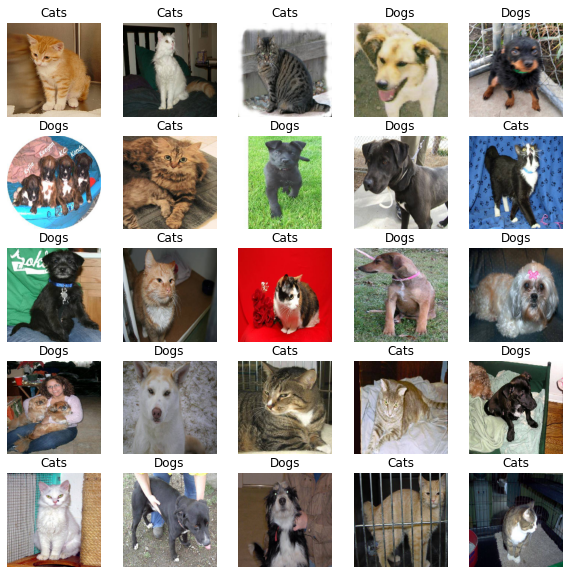

In [12]:
image_batch, label_batch = next(train_it)
show_batch(image_batch, label_batch)

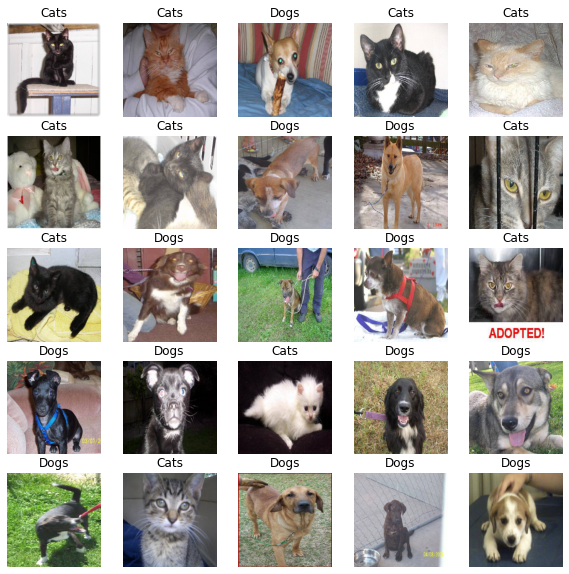

In [13]:
image_batch, label_batch = next(val_it)
show_batch(image_batch, label_batch)

## Model Building

In [0]:
# mymodel = ResNet50V2()
# mymodel.summary()

In [15]:
mymodel = ResNet50V2(include_top=False,input_shape=(256, 256, 3))
x = mymodel.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='relu')(x)

# mymodel.summary()
model2 = Model(inputs=mymodel.input, outputs=x)
model2.summary()

94674944/94668760 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_____________________________

In [16]:
## Freezing Layer

for layer in model2.layers[:-2]:
    layer.trainable = False

for layer in model2.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1f6662a668> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1f6662a828> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1f66613d68> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1f665ff780> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1f6660ecc0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f1f66640ac8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f1f666b0c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1f665cfa58> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f1f665cfe10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f1f665e3ba8> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1f66590e48> False
<tensorflow.python.keras.lay

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['acc'])


In [19]:
model_info = model2.fit_generator(train_it,
                      steps_per_epoch=len(train_it), 
                      validation_data = val_it, 
                      validation_steps = len(val_it),
                      epochs=10, verbose=1,callbacks =[checkpoint])

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
16/32 [==============>...............] - ETA: 6s - loss: 0.1067 - acc: 0.9700
Epoch 00001: val_acc improved from -inf to 0.97000, saving model to weights-improvement-01-0.97.hdf5
32/32 [==============================] - 40s 1s/step - loss: 0.9597 - acc: 0.8570 - val_loss: 0.1067 - val_acc: 0.9700
Epoch 2/10
16/32 [==============>...............] - ETA: 5s - loss: 0.1037 - acc: 0.9870
Epoch 00002: val_acc improved from 0.97000 to 0.98700, saving model to weights-improvement-02-0.99.hdf5
32/32 [==============================] - 13s 401ms/step - loss: 0.1822 - acc: 0.9590 - val_loss: 0.1037 - val_acc: 0.9870
Epoch 3/10
16/32 [==============>...............] - ETA: 4s - loss: 0.0875 - acc: 0.9880
Epoch 00003: val_acc improved from 0.98700 to 0.98800, saving model to weights-improvement-03-0.99.hdf5
32/32 [==============================] - 13s 397ms/step - loss: 0.2334 - acc: 0.9620 - va

In [0]:
# pick the model of highest val accuracy 
model2.load_weights("weights-improvement-07-0.99.hdf5")

## Results Visualization

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

def image_process(model, layer, img, class_idx, preprocess_func=None, preprocess_img=min_max_scale,
          show=False):
  x = np.expand_dims(image.img_to_array(img), axis=0)
  img = np.copy(img)
  class_idx = np.argmax(class_idx, axis=0) if type(class_idx) == list or type(class_idx) == np.ndarray else class_idx
  preds = model.predict(x)
  preds = np.argmax(preds, axis=1)[0]

  class_output = model.output[:, class_idx]
  return img, preds

In [0]:
#function to show all misclassified images
def show_misclassified(model, layer, iterator, classes=None, preprocess_func=None, preprocess_img=min_max_scale,
                                    image_size_multiplier=3, examples=25,
                                    show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(examples / columns))
    images = []
    labels = []
    predictions = []
    while len(images) < examples:
        batchX, batchY = iterator.next()
        preds = model.predict(batchX)
        X, y_true, y_pred = find_misclassified(batchX, batchY, preds)
        images.extend(X)
        labels.extend(y_true)
        predictions.extend(y_pred)

    images = images[:examples]
    labels = labels[:examples]
    predictions = predictions[:examples]
    show_examples(model, layer, images, labels, classes=classes, preprocess_func=preprocess_func,
                               preprocess_img=preprocess_img, image_size_multiplier=image_size_multiplier)


In [0]:
#function returning all the classes.
def get_mylabels():
    return ['dogs','cats']

#function to find misclassified images. if the predicted and 
#actual variable doesnot match then they are misclassified.
def find_misclassified(X, y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    misclassified = y_true != y_pred
    X = X[misclassified]
    y_true = y_true[misclassified]
    y_pred = y_pred[misclassified]
    return X, y_true, y_pred
  


def show_examples(model, layer, images, labels, classes=None, preprocess_func=None, preprocess_img=min_max_scale,
                               image_size_multiplier=3,
                               show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(len(images) / columns))
    num_inner_rows = int(show_actual)
    labels = np.argmax(labels, axis=1) if type(labels[0]) == list or type(labels[0]) == np.ndarray else labels
    fig_height = rows * image_size_multiplier * num_inner_rows
    fig_width = columns * image_size_multiplier
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
    for i in range(rows * columns):
        if i >= len(images):
            break
        x = images[i]
        y = labels[i]
        img,prediction = image_process(model, layer, x, y, preprocess_func=preprocess_func,
                                                             preprocess_img=preprocess_img, show=False)
        inner = gridspec.GridSpecFromSubplotSpec(num_inner_rows, 1,
                                                 subplot_spec=outer[i], wspace=0.0, hspace=0.05)

        imgs = []
        if show_actual:
            imgs.append(img)
        label = classes[y] if classes is not None else ""
        label = label.split(' ', 1)[0]
        prediction = classes[prediction]
        titles = [("Actual:" + label + " Pred:" + prediction).replace(' ', '\n')]
        for j in range(num_inner_rows):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(imgs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(titles.pop() if len(titles) > 0 else "")
            fig.add_subplot(ax)

    fig.show()

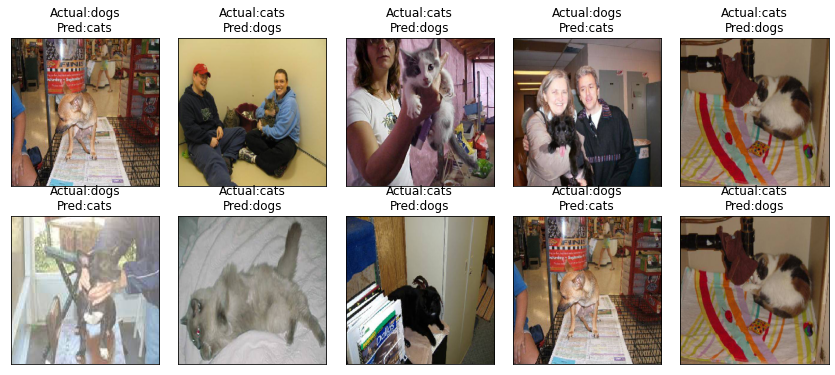

In [24]:
show_misclassified(model2,"conv5_block3_out",val_it,classes=get_mylabels(),preprocess_func=None,image_size_multiplier=3, examples=10,preprocess_img=None,show_heatmap=True)

In [0]:
def grad_cam(input_model, image, layer_name,H=256,W=256):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    #grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    #print (cam)

    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = scipy.ndimage.interpolation.zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

Prediction: Cat
Assets/cat.jpeg
Prediction: Dog
Assets/dog.jpeg


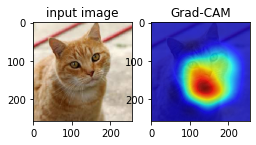

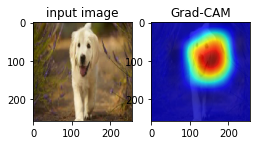

In [27]:
paths = ["cat.jpeg","dog.jpeg"]
# paths = ["cat_dog.png"]""
for path in paths:
    path = os.path.join("Assets",path)
    orig_img = np.array(load_img(path,target_size=(256,256)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(256,256)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    predictions = model2.predict(img)
    top_n = 5
    top = predictions[0]
    # print(top, predictions)
    if top[0]>top[1]:
      print("Prediction: Dog")
    else:
      print("Prediction: Cat")
    cls = np.argsort(predictions[0])[-top_n:][::-1]
    
    gradcam=grad_cam(model2,img,layer_name='conv5_block3_out')
    print(path)
    # print("class activation map for:",top[0])
    fig, ax = plt.subplots(nrows=1,ncols=2)
    plt.subplot(131)
    plt.imshow(orig_img)
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(orig_img)
    plt.imshow(gradcam,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM")